In [1]:
import pandas as pd
from pandas import Series
import math
import requests
import json
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from functools import partial
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
bitcoin_series = pd.read_csv('../data/Bitcoin.csv')
bitcoin_series.columns = ['time', 'price','volume']
bitcoin_series['time'] = pd.to_datetime(bitcoin_series['time'])#, unit='s')
bitcoin_series.head()

,time,price,volume
0,2013-03-28,86.4500,6200708.085
1,2013-03-29,88.1875,3733639.335
2,2013-03-30,91.1675,1728643.570
3,2013-03-31,92.5050,990090.160
4,2013-04-01,98.8175,4575292.720


## 时间序列的预测只能用一个dimension作为input吗？？？

In [6]:
bitcoin_series.set_index('time',inplace =True)
ts = bitcoin_series['price']
ts.head(5)

time
2013-03-28    86.4500
2013-03-29    88.1875
2013-03-30    91.1675
2013-03-31    92.5050
2013-04-01    98.8175
Name: price, dtype: float64

### RMSE应该是 squart(sum/n)吧，但是他的结果看起来是只有一天的？？？

In [9]:
ts_log = np.log(ts)
ts_log.head()

time
2013-03-28    4.459566
2013-03-29    4.479465
2013-03-30    4.512698
2013-03-31    4.527263
2013-04-01    4.593275
Name: price, dtype: float64

### log -> differentiate -> modeling

In [10]:
diff_2 = ts_log.diff(1)
diff_2.dropna(inplace=True)

from statsmodels.tsa.arima_model import ARMA
# model是基于数据进行过log / 差分处理之后建立的模型
# 定阶：
# model 没有体现是用哪些天算的啊？
model = ARMA(diff_2, order=(4, 5))  
results_AR = model.fit(disp=-1) 
#Prediction for 7 dyas
start_ind = '2018-06-28'
end_ind = '2018-07-4'
# 预测7天
predict = results_AR.predict(start =start_ind,end =end_ind)
predict.head()

/Users/libaisun/virtual/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2018-06-28    0.002362
2018-06-29    0.007552
2018-06-30    0.010605
2018-07-01    0.013649
2018-07-02   -0.012322
Freq: D, dtype: float64

In [14]:
predictions_ARIMA_diff = pd.Series(predict, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# 选择第一列
predictions_ARIMA_log = pd.Series(ts_log[start_ind:end_ind].iloc[0], index=ts_log[start_ind:end_ind].index)
predictions_ARIMA_log.head()
# 是5天诶！
# 而且为啥都是一样的？

time
2018-06-28    8.700737
2018-06-29    8.700737
2018-06-30    8.700737
2018-07-01    8.700737
2018-07-02    8.700737
dtype: float64

Text(0.5,1,'RMSE: 12.7352')

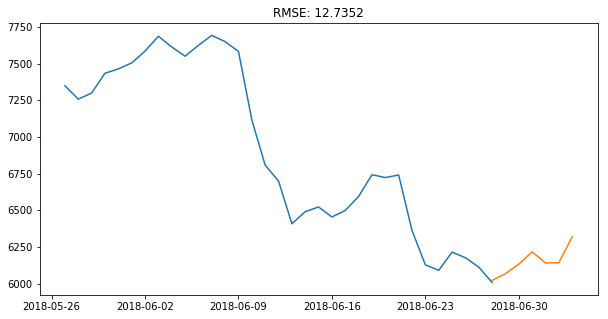

In [15]:
# 30days
feed_ts = ts['2018-05-27' : '2018-6-28']

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
# 原来进行了log，现在exp回去
# 但是差分回去了吗？？？
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(10,5))
plt.plot(feed_ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts[start_ind:end_ind])**2)/ts.size))

## 以上，哪里体现了model是用30days train的呢？

- 数据显示，他的模型没有用不同的天数train，因为7/14/30 days，他同一天的预测都是一样的
- RMSE的计算公式貌似也不对

In [2]:
from statsmodels.tsa.arima_model import ARIMA

In [3]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |  If exogenous variables are given, then the model that is fit is
 

In [4]:
a = [1, 2, 3]
b = [4, 5, 6]

In [6]:
import numpy as np
data = np.dstack([a, b])
data

array([[[1, 4],
        [2, 5],
        [3, 6]]])

In [7]:
data.shape

(1, 3, 2)

In [10]:
import pandas as pd
c = pd.DataFrame(a).shift(1)
c

,0
0,NaN
1,1.0
2,2.0
